In [ ]:
from huggingface_hub import hf_hub_download
import json
import os
import zipfile
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from typing import Tuple
import shutil
import numpy as np
import torch.nn as nn
import torch.optim as optim
import sklearn

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from Data_Extraction import get_data

ModuleNotFoundError: No module named 'Data_Extraction'

### Download Data locally

In [ ]:
# Static mappings
static_base = "/content/drive/MyDrive/kilter/static"

with open(f"{static_base}/id_to_token.json", "r") as f:
    id_to_token = json.load(f)

with open(f"{static_base}/token_to_id.json", "r") as f:
    token_to_id = json.load(f)

with open(f"{static_base}/layoutInfo.json", "r") as f:
    layout_info = json.load(f)

with open(f"{static_base}/leds.json", "r") as f:
    leds = json.load(f)

with open(f"{static_base}/placements.json", "r") as f:
    placements = json.load(f)

with open(f"{static_base}/roles.json", "r") as f:
    roles = json.load(f)

# Dataset file
data_base = "/content/drive/MyDrive/kilter/data"

with open(f"{data_base}/single_board.json", "r") as f:
    data = json.load(f)

print("✅ Loaded everything!")
print("Dataset size:", len(data))
print("First sample:", data[0])
print("Vocab size:", len(id_to_token))
print("Total placements:", len(placements))
print("Total roles:", len(roles))
print("Total LEDs:", len(leds))
print("Layout keys:", list(layout_info.keys()))

✅ Loaded everything!
Dataset size: 222624
First sample: {'source': [1270, 1239], 'target': [42, 1194, 156, 1194, 94, 1195, 169, 1195, 115, 1195, 201, 1195, 84, 1195, 181, 1195, 68, 1195, 184, 1196, 29, 1197, 36, 1197, 168, 1197, 206, 1197, 114, 1197, 89, 1197, 63, 1197]}
Vocab size: 1279
Total placements: 1191
Total roles: 30
Total LEDs: 1191
Layout keys: ['8x12Home', '7x10Small', '7x10FullRideLEDKit', '7x10MainlineLEDKit', '7x10AuxiliaryLEDKit', '10x10FullRideLEDKit', '10x10MainlineLEDKit', '12x14Commerical', '12x12withkickboardSquare', '12x12withoutkickboardSquare', '16x12SuperWide', '10x12MainlineLEDKit', '10x12FullRideLEDKit', '8x12MainlineLEDKit', '8x12FullRideLEDKit', '10x10AuxiliaryLEDKit']


In [ ]:
# 1. Count problems per board_id
board_counts = Counter(sample["source"][0] for sample in data)

# 2. Map board IDs to readable names
board_names = {bid: id_to_token[str(bid)] for bid in board_counts.keys()}



# 3. Prepare data
labels = [board_names[bid] for bid in board_counts.keys()]
sizes = [board_counts[bid] for bid in board_counts.keys()]



In [ ]:
from typing import Tuple
import torch
from torch.nn.utils.rnn import pad_sequence

def filter_hold_tokens(sequence: list[int], id_to_token: dict) -> list[int]:
    """
    Keep only tokens that represent physical holds (start with 'p').
    """
    return [
        token_id for token_id in sequence
        if id_to_token.get(str(token_id), "").startswith("p")
    ]

def data_by_name(
    target_board_name: str,
    data: list,
    id_to_token: dict,
    max_rout_len: int = 100
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Filter dataset by board name and return sources and padded target sequences,
    keeping only physical hold tokens (no roles).
    """
    # 1. Find board ID by name
    board_id = None
    for k, v in id_to_token.items():
        if v == target_board_name:
            board_id = int(k)
            break

    if board_id is None:
        raise ValueError(f"Board name '{target_board_name}' not found in vocabulary.")

    sources, targets = [], []

    for sample in data:
        if sample["source"][0] == board_id:
            src = torch.tensor(sample["source"][1], dtype=torch.long)
            tgt = filter_hold_tokens(sample["target"], id_to_token)

            if len(tgt) < max_rout_len:
                sources.append(src)
                targets.append(torch.tensor(tgt, dtype=torch.long))

    sources = torch.stack(sources, dim=0)                  # (N, 1) difficulty levels
    targets = pad_sequence(targets, batch_first=True, padding_value=0)  # (N, L_max)

    return targets, sources


In [ ]:
X, y = data_by_name("12 x 12 with kickboard Square",
                    data=data,
                    id_to_token=id_to_token,
                    max_rout_len=20)

print("data shape:", X.shape)
print("label source:", y.shape)
print("First data sequence:", X[0, :10])



data shape: torch.Size([35010, 19])
label source: torch.Size([35010])
First data sequence: tensor([ 42, 156,  94, 169, 115, 201,  84, 181,  68, 184])


In [ ]:
def get_layout_id_by_name(name: str, id_to_token: dict= id_to_token) -> int:
    for token_id, token_name in id_to_token.items():
        if token_name == name:
            return int(token_id)
    raise ValueError(f"Layout name '{name}' not found in id_to_token.")

target_board_name = "16 x 12 Super Wide"

layout_id = get_layout_id_by_name(name = target_board_name)
print("Layout ID:", layout_id)


def id_to_placement(token_id: int, id_to_token: dict=id_to_token, placements: dict=placements) -> tuple:
    """
    Given a token ID, return the (x, y) coordinates of the hold if it's a valid 'p####' token.

    Args:
        token_id (int): Integer ID from the route sequence.
        id_to_token (dict): Mapping from ID to token strings.
        placements (dict): Mapping from placement ID (string) to {'x': int, 'y': int}.

    Returns:
        tuple or None: (x, y) coordinates if found, else None.
    """
    token = id_to_token.get(str(token_id))
    #print(token)
    if token and token.startswith("p"):
        placement_id = token[1:]  # remove 'p'
        if placement_id in placements:
            x = placements[placement_id]["x"]
            y = placements[placement_id]["y"]
            return x, y
    return None

def get_hold_set(token_id: int, id_to_token: dict=id_to_token,placements: dict= placements) -> int:
    """
    Get the layout ID (`set`) that a hold belongs to.

    Args:
        hold_id (int): The placement ID (e.g. 1176)
        placements (dict): Dictionary loaded from placements.json

    Returns:
        int: The layout ID (set) the hold belongs to
    """
    token = id_to_token.get(str(token_id))
    #print(token)
    if token and token.startswith("p"):
        placement_id = token[1:]  # remove 'p' prefix
        #print(placement_id)
        if placement_id in placements:
            return placements[placement_id]["set"]
    return None

def get_sets_from_X(
    X: torch.Tensor,
    id_to_token: dict,
    placements: dict
) -> list[int]:
    """
    For each hold ID in tensor X, get the corresponding layout `set` ID.
    Raise error if any hold is not found in placements.

    Args:
        X (Tensor): Tensor of shape (N, L) with hold token IDs.
        id_to_token (dict): Token ID -> token string (e.g., "p1234").
        placements (dict): Placement ID -> placement info including "set".

    Returns:
        List[int]: List of set IDs used in X.
    """
    sets = set()

    for sample in X:
        for token_id in sample:
            if token_id.item() == 0:
                continue  # Skip padding
            set_id = get_hold_set(token_id.item(), id_to_token, placements)
            if set_id is None:
                raise ValueError(f"Hold ID {token_id.item()} is not mapped to any set.")
            sets.add(set_id)

    return list(sets)


sets_in_X = get_sets_from_X(X, id_to_token, placements)
print("Layout in placments sets used in X:", sets_in_X)


Layout ID: 1273
Layout in placments sets used in X: [1, 20]


## To creat an one_hot_vector extract board size from dataset

In [ ]:
def get_board_dimensions(placements: dict, set_ids: list[int]) -> tuple[int, int]:
    """
    Get the max (x, y) dimensions of a board by inspecting all holds in given sets.

    Args:
        placements (dict): Loaded placements.json
        set_ids (list[int]): Which `set` IDs to include (e.g., [1, 20])

    Returns:
        (width, height): Tuple of max X and Y +1 (assuming 0-based indexing)
    """
    xs, ys = [], []

    for hold in placements.values():
        if hold["set"] in set_ids:
            xs.append(hold["x"])
            ys.append(hold["y"])

    max_width = max(xs) + 1
    max_height = max(ys) + 1

    min_width = min(xs) - 1
    min_height = min(ys) + 1

    return max_width, max_height, min_width, min_height


max_width, max_height, min_width, min_height = get_board_dimensions(placements, sets_in_X)
max_width, max_height, min_width, min_height


(165, 177, -21, 5)

In [ ]:
def route_to_onehot_vector(route: torch.Tensor, unique_tokens: torch.Tensor) -> torch.Tensor:
    """
    Converts a route (1D tensor of token IDs) into a one-hot vector
    of length equal to number of unique tokens in the dataset.

    Args:
        route (torch.Tensor): 1D tensor of token IDs.
        unique_tokens (torch.Tensor): 1D tensor of all unique token IDs.

    Returns:
        torch.Tensor: One-hot vector of shape (len(unique_tokens),)
    """
    one_hot = torch.zeros(len(unique_tokens), dtype=torch.float)

    # Build token_id -> index mapping
    token_to_index = {int(token): idx for idx, token in enumerate(unique_tokens)}

    for token_id in route:
        token_id = int(token_id)
        if token_id in token_to_index:
            one_hot[token_to_index[token_id]] = 1

    return one_hot


# Suppose X is your route tensor of shape [N, L]
unique_token_ids = torch.unique(X)

# Take one route (row from X)
sample_route = X[8]

# Convert to one-hot over unique tokens
hot_one_sample = route_to_onehot_vector(sample_route, unique_token_ids)

print("One-hot vector shape:", hot_one_sample.shape)
print("Nonzero entries:", hot_one_sample)





One-hot vector shape: torch.Size([477])
Nonzero entries: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
from typing import Dict, Tuple

def hot_one_to_positions(
    route: torch.Tensor,
    unique_token_ids: torch.Tensor
) -> torch.Tensor:
    """
    Converts a one-hot route vector back to token IDs.

    Args:
        route (torch.Tensor): One-hot tensor of shape (len(unique_token_ids),)
        unique_token_ids (torch.Tensor): 1D tensor of token IDs used for one-hot encoding.

    Returns:
        torch.Tensor: Tensor of token IDs corresponding to active (1) positions in `route`.
    """
    if route.dim() != 1 or route.shape[0] != unique_token_ids.shape[0]:
        raise ValueError("Shape mismatch between route and unique_token_ids")

    active_indices = torch.nonzero(route, as_tuple=False).squeeze(1)
    token_ids = unique_token_ids[active_indices]
    return token_ids



tokens = hot_one_to_positions(hot_one_sample, unique_token_ids)
print(torch.sort(sample_route))
print(torch.sort(tokens))  # Output: tensor([102, 104])

print(len(sample_route), len(tokens))

torch.return_types.sort(
values=tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,  12,  62, 134, 170, 181,
        252, 256, 343, 379, 495]),
indices=tensor([18, 17, 16, 15, 14, 13, 12, 10, 11,  0,  6,  9,  3,  7,  8,  5,  4,  2,
         1]))
torch.return_types.sort(
values=tensor([  0,  12,  62, 134, 170, 181, 252, 256, 343, 379, 495]),
indices=tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))
19 11


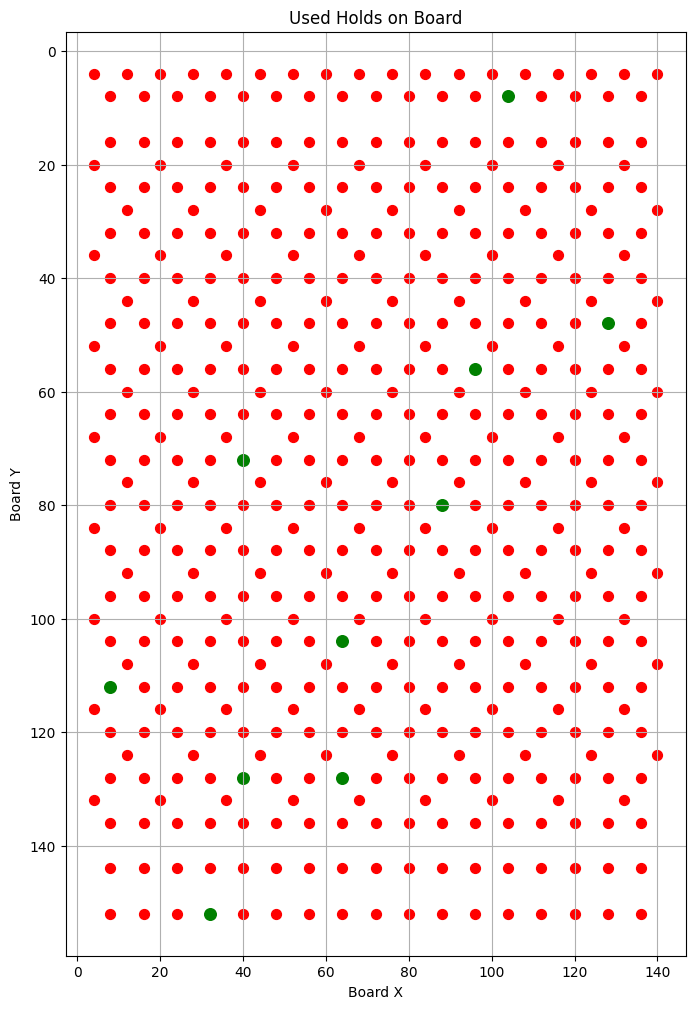

In [ ]:
def plot_used_holds(all_holds:torch.Tensor,
                    used_holds:torch.tensor=None,
                    placements= placements,
                    title="Used Holds on Board"):

    #all Holds
    xs, ys = [], []

    for hold in all_holds:
      each_token = id_to_token.get(str(hold.item()))[1:]

      if hold != 0:
        each_place = placements.get(each_token)
        xs.append(each_place["x"])
        ys.append(each_place["y"])

    #used in route:

    xs_used, ys_used = [], []
    if used_holds != None:
      for hold in used_holds:
            each_token = id_to_token.get(str(hold.item()))[1:]

            if hold != 0:
              each_place = placements.get(each_token)
              xs_used.append(each_place["x"])
              ys_used.append(each_place["y"])

    plt.figure(figsize=(8, 12))
    plt.scatter(xs, ys, c='red', s=50)
    if used_holds != None:
      plt.scatter(xs_used, ys_used, c='green', s=70)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Board X")
    plt.ylabel("Board Y")
    plt.grid(True)
    plt.show()


#print(X[0])

flat_X = torch.flatten(X)

used_holds = torch.unique(X)

#print(used_holds)

eg_hold = used_holds[6]
eg_hold = eg_hold.item()
#print(eg_hold)

eg_hold_token = id_to_token.get(str(eg_hold))[1:]

#print((eg_hold_token))

#print(placements.get(eg_hold_token)["x"])

plot_used_holds(used_holds, sample_route)


In [ ]:
print((torch.unique(y)))

tensor([1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244,
        1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253])


In [ ]:
# Mapping y values from 1233 (4a) - 1253(8b)
# and back
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F



y_indices = y - y.min()

num_classes = int(y_indices.max().item() + 1)
y_hot = F.one_hot(y_indices, num_classes=num_classes).float()

y_hot.shape







torch.Size([35010, 21])

In [ ]:
# bring X into hot one fomation wer the used holds in an rout are labelt

X_hot = torch.stack([route_to_onehot_vector(row, unique_token_ids) for row in X], dim=0)

In [ ]:
X_hot.shape


torch.Size([35010, 477])

# Let the datasience begin :)

In [ ]:
torch.__version__
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X_train, X_test, y_train, y_test = train_test_split(X_hot,
                                                    y_hot,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42)

X_train = X_train.float().to(device)
X_test = X_test.float().to(device)
y_train = y_train.float().to(device)
y_test = y_test.float().to(device)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)


train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([64, 477]), torch.Size([64, 21]))

In [ ]:
y_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
class ShallowMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(ShallowMLP, self).__init__()
        self.model = nn.Sequential(
          nn.Linear(input_dim, hidden_dim),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(hidden_dim, hidden_dim),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(hidden_dim, num_classes)   # classification head
      )


    def forward(self, x):
        return self.model(x)





In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
def acc_fn(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    pred = torch.argmax(y_pred, dim=1)
    true = torch.argmax(y_true, dim=1)

    return (pred == true).float().mean()


def acc_fn_tolerant(y_pred: torch.Tensor, y_true: torch.Tensor, tol: int = 1) -> torch.Tensor:
    # predicted and true indices
    pred = torch.argmax(y_pred, dim=1)
    true = torch.argmax(y_true, dim=1)

    # absolute difference
    diff = (pred - true).abs()

    # correct if difference <= tol
    return (diff <= tol).float().mean()

In [ ]:
# -----------------------------
schallowMLP = ShallowMLP(input_dim=X_hot.shape[1],
                         hidden_dim=32,
                         num_classes= y_hot.shape[1]
                         ).to(device)


all_train_loss, all_train_acc, all_test_loss, all_test_acc = [], [], [], []




In [ ]:
from tqdm.auto import tqdm






loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(schallowMLP.parameters(), lr=1e-3, weight_decay=1e-5 )



# -----------------------------
# Training loop
# -----------------------------

train_time_start_on_cpu = timer()

epochs = 25



for epoch in tqdm(range(epochs)):
  #print(f"Epochs: {epoch} -----------")

  train_loss = 0
  train_acc = 0

  for batch, (X, y) in enumerate(train_loader):

    schallowMLP.train()

    X.to(device)
    y.to(device)



    y_pred = schallowMLP(X)




    loss = loss_fn(y_pred, y)

    acc = acc_fn(y_pred, y).item()




    train_loss += loss.item()
    train_acc += acc

    optimizer.zero_grad()

    #loss = torch.tensor(0.1, requires_grad=True)
    loss.backward()

    optimizer.step()


  train_loss /= len(train_loader)
  train_acc /= len(train_loader)

  all_train_loss.append(train_loss)
  all_train_acc.append(train_acc)


  test_loss, test_acc = 0, 0
  schallowMLP.eval()
  with torch.inference_mode():
    for X_test, y_test in test_loader:
      test_pred = schallowMLP(X_test)

      test_loss += loss_fn(test_pred, y_test).item()
      test_acc +=  acc_fn(test_pred, y_test).item()


    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    all_test_loss.append(test_loss)
    all_test_acc.append(test_acc)



  if epoch % 10 == 0:

    print(f"\nEpoch: {epoch} | Train loss: {train_loss:.5f} |Train acc: {train_acc:.5f} | Test loss: {test_loss:.5f} |Test acc: {test_acc:.5f}")









  0%|          | 0/25 [00:00<?, ?it/s]


Epoch: 0 | Train loss: 2.69615 |Train acc: 0.12285 | Test loss: 2.45012 |Test acc: 0.16161

Epoch: 10 | Train loss: 2.22491 |Train acc: 0.20198 | Test loss: 2.24361 |Test acc: 0.19427

Epoch: 20 | Train loss: 2.14913 |Train acc: 0.22053 | Test loss: 2.25824 |Test acc: 0.19422


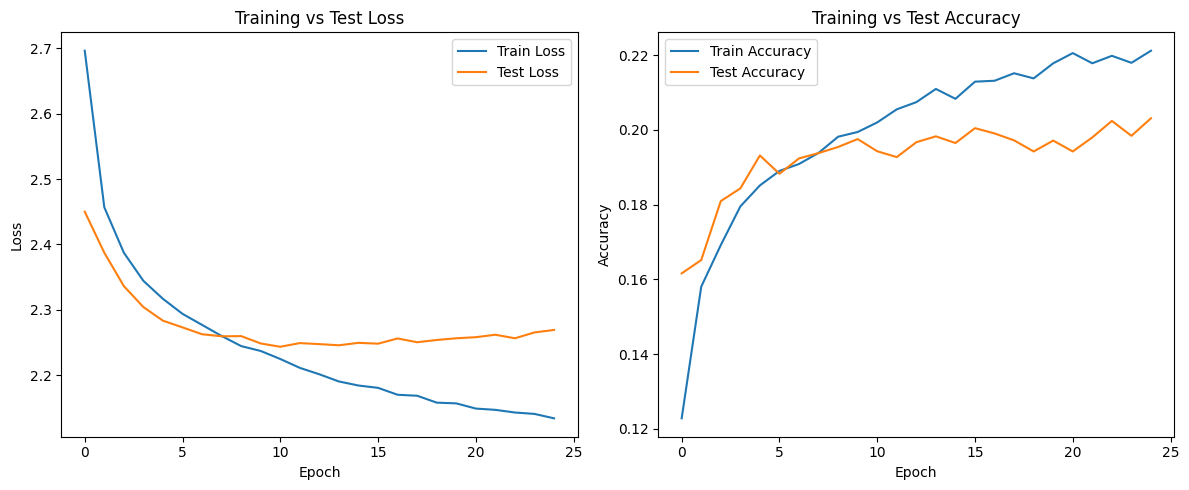

In [ ]:
epochs = range(len(all_train_loss))

plt.figure(figsize=(12,5))

# ---- Loss plot ----
plt.subplot(1,2,1)
plt.plot(epochs, all_train_loss, label="Train Loss")
plt.plot(epochs, all_test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()

# ---- Accuracy plot ----
plt.subplot(1,2,2)
plt.plot(epochs, all_train_acc, label="Train Accuracy")
plt.plot(epochs, all_test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
all_preds = []
all_labels = []

schallowMLP.eval()
with torch.inference_mode():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = schallowMLP(X_batch)



        preds = torch.argmax(y_pred, dim=1)   # predicted class indices
        y_batch = torch.argmax(y_batch, dim=1)



        all_preds.append(preds.cpu())
        all_labels.append(y_batch.cpu())




all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

all_preds_onehot = np.eye(num_classes)[all_preds]
all_labels_onehot = np.eye(num_classes)[all_labels]

Normal acc: tensor(0.1797)
±1 acc: 0.4705798327922821


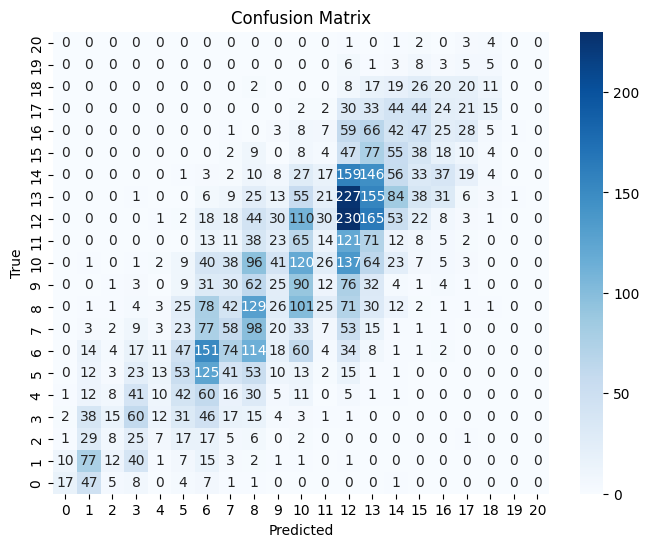

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


print("Normal acc:", acc_fn(torch.Tensor(all_preds_onehot), torch.Tensor(all_labels_onehot)))
print("±1 acc:", acc_fn_tolerant(torch.Tensor(all_preds_onehot), torch.Tensor(all_labels_onehot), tol=1).item())

cm = confusion_matrix(all_labels, all_preds)
classes = y_hot.shape[1]


plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Invert x-axis
plt.gca().invert_yaxis()

plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np



# MAE
mae = mean_absolute_error(all_preds, all_labels)

# RMSE (square root of MSE)
rmse = mean_squared_error(all_preds, all_labels)

print("MAE:", mae)
print("RMSE:", rmse)



MAE: 1.979291630962582
RMSE: 6.7644958583261925


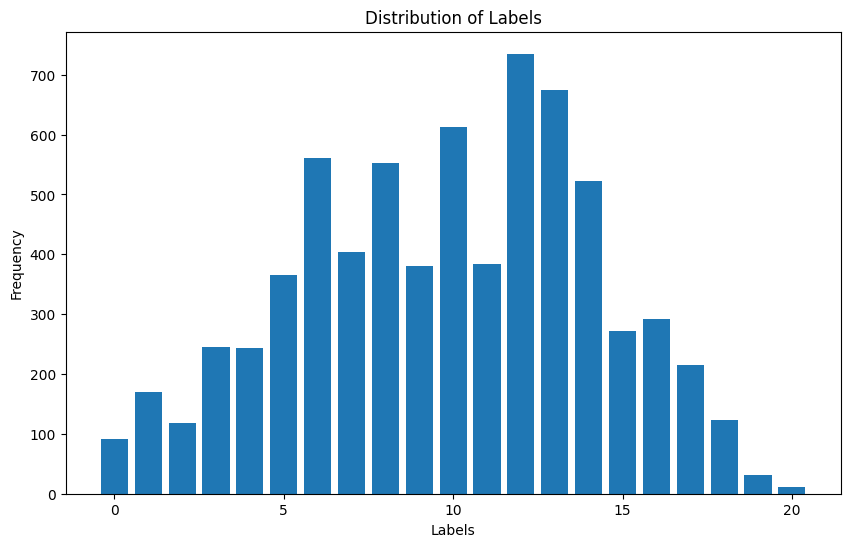

In [ ]:
# Count unique labels
unique, counts = np.unique(all_labels, return_counts=True)

# Plot distribution
plt.figure(figsize=(10,6))
plt.bar(unique, counts)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Distribution of Labels")
plt.show()

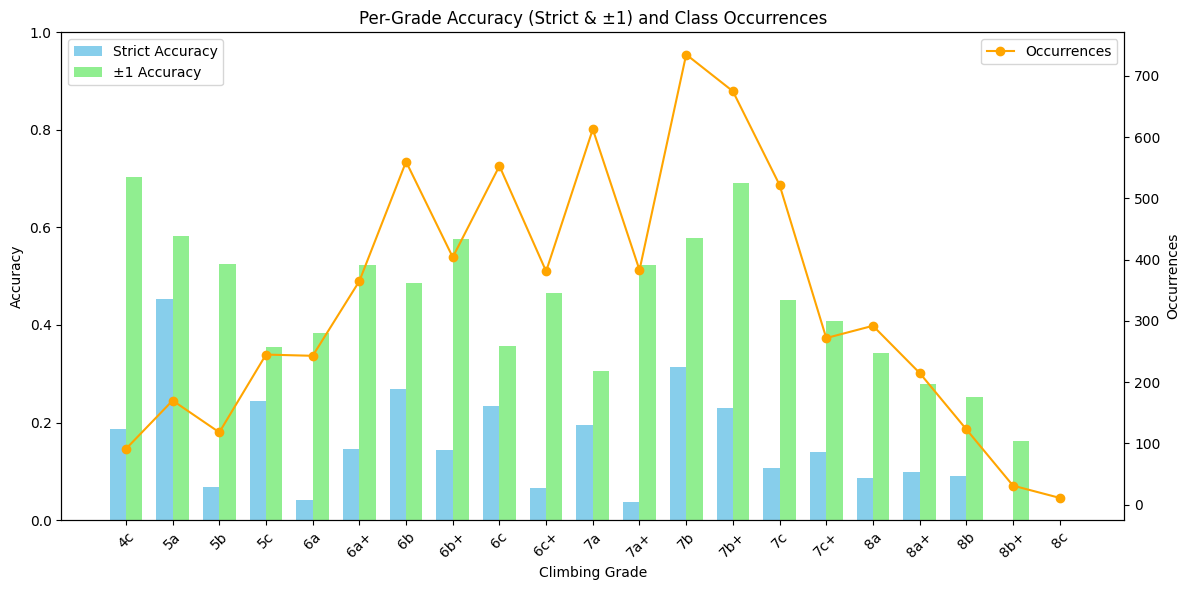

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Example grade list (adjust to match your dataset’s range)
grades = [
    "4c", "5a", "5b", "5c",
    "6a", "6a+", "6b", "6b+",
    "6c", "6c+", "7a", "7a+",
    "7b", "7b+", "7c", "7c+",
    "8a", "8a+", "8b", "8b+",
    "8c"
]

def per_class_accs(preds_onehot, labels_onehot, tol=0):
    preds = preds_onehot.argmax(dim=1)
    labels = labels_onehot.argmax(dim=1)

    unique_labels, counts = torch.unique(labels, return_counts=True)
    strict_accs, tol_accs = [], []

    for lab in unique_labels:
        mask = labels == lab
        if mask.sum() == 0:
            strict_accs.append(0.0)
            tol_accs.append(0.0)
            continue

        # Strict accuracy
        strict = (preds[mask] == labels[mask]).float().mean().item()
        strict_accs.append(strict)

        # Tolerant accuracy (within ± tol)
        correct_tol = ((preds[mask] - labels[mask]).abs() <= tol).float().mean().item()
        tol_accs.append(correct_tol)

    return unique_labels.numpy(), np.array(strict_accs), np.array(tol_accs), counts.numpy()

# Compute per-grade accs and counts
labels, strict_accs, tol_accs, counts = per_class_accs(
    torch.Tensor(all_preds_onehot), torch.Tensor(all_labels_onehot), tol=1
)

grade_labels = [grades[i] for i in labels]

# Plot
fig, ax1 = plt.subplots(figsize=(12,6))

x = np.arange(len(labels))
width = 0.35  # width of bars

# Bars: strict vs tolerant
ax1.bar(x - width/2, strict_accs, width, label="Strict Accuracy", color="skyblue")
ax1.bar(x + width/2, tol_accs, width, label="±1 Accuracy", color="lightgreen")

ax1.set_xlabel("Climbing Grade")
ax1.set_ylabel("Accuracy")
ax1.set_ylim(0, 1)
ax1.set_xticks(x)
ax1.set_xticklabels(grade_labels, rotation=45)

# Occurrence line on secondary axis
ax2 = ax1.twinx()
ax2.plot(x, counts, color="orange", marker="o", label="Occurrences")
ax2.set_ylabel("Occurrences")

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.title("Per-Grade Accuracy (Strict & ±1) and Class Occurrences")
plt.tight_layout()
plt.show()
